In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class FastTextEmbedding:
    def __init__(self, model_name='fasttext-wiki-news-subwords-300'):
        print("Cargando modelo FastText...")
        self.model = api.load(model_name)
        self.embedding_dim = self.model.vector_size
        
    def tokenize(self, text):
        return word_tokenize(text.lower())
    
    def get_embedding_matrix(self, vocab):
        embedding_matrix = np.zeros((len(vocab), self.embedding_dim))
        for word, idx in vocab.items():
            if word in self.model.key_to_index:
                embedding_matrix[idx] = self.model[word]
        return embedding_matrix

In [4]:
# Carga de datos
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, vocab, fasttext_embedder, max_len=256):
        self.reviews = reviews
        self.labels = labels
        self.vocab = vocab
        self.fasttext_embedder = fasttext_embedder
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        # Tokenización
        tokens = word_tokenize(str(self.reviews[idx]).lower())
        
        # Conversión a índices
        token_indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        
        # Padding o truncamiento
        if len(token_indices) > self.max_len:
            token_indices = token_indices[:self.max_len]
        else:
            token_indices = token_indices + [self.vocab['<PAD>']] * (self.max_len - len(token_indices))
        
        return {
            'input_ids': torch.tensor(token_indices, dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [5]:
# Modelo RNN
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embedding_matrix), 
            freeze=False  # Permite ajuste fino
        )
        
        # Capas con regularización
        self.rnn = nn.LSTM(
            input_size=embedding_matrix.shape[1], 
            hidden_size=hidden_dim, 
            num_layers=2,  # Reducir capas
            batch_first=True,
            dropout=0.4,   # Dropout entre capas
            bidirectional=True  # Bidireccional para más contexto
        )
        
        # Capa fully connected con regularización
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),  # Ajustar por bidireccional
            nn.BatchNorm1d(128),  # Normalización por lotes
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, _) = self.rnn(embedded)
        
        # Concatenar últimos estados de capas forward y backward
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)

In [6]:
def build_vocab(texts, max_vocab_size=20000):
    word_counts = {}
    for text in texts:
        tokens = word_tokenize(text.lower())
        for token in tokens:
            word_counts[token] = word_counts.get(token, 0) + 1
    
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    vocab = {
        '<PAD>': 0, 
        '<UNK>': 1
    }
    for word, _ in sorted_words[:max_vocab_size-2]:
        vocab[word] = len(vocab)
    
    return vocab

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [8]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    #early_stopping = EarlyStopping(patience=5, min_delta=0.001)
    early_stopping = EarlyStopping(patience=8, min_delta=0.001)
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validación
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calcular métricas
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Época {epoch+1}/{num_epochs}')
        print(f'Pérdida de entrenamiento: {train_loss_avg:.4f}, Precisión de entrenamiento: {train_accuracy:.4f}')
        print(f'Pérdida de validación: {val_loss_avg:.4f}, Precisión de validación: {val_accuracy:.4f}')
        
        # Comprobar early stopping
        if early_stopping(val_loss_avg):
            print(f"Early stopping en época {epoch+1}")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [9]:
# Evaluación del modelo
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Métricas de rendimiento
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Precisión: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    
    # Visualización de matriz de confusión
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiquetas Reales')
    plt.xlabel('Predicciones')
    plt.show()

Cargando modelo FastText...
Iniciando entrenamiento...
Época 1/20
Pérdida de entrenamiento: 0.6000, Precisión de entrenamiento: 0.6365
Pérdida de validación: 1.2828, Precisión de validación: 0.6016
Época 2/20
Pérdida de entrenamiento: 0.2718, Precisión de entrenamiento: 0.8912
Pérdida de validación: 0.2780, Precisión de validación: 0.8836
Época 3/20
Pérdida de entrenamiento: 0.1788, Precisión de entrenamiento: 0.9329
Pérdida de validación: 0.3571, Precisión de validación: 0.8678
Época 4/20
Pérdida de entrenamiento: 0.1140, Precisión de entrenamiento: 0.9605
Pérdida de validación: 0.3271, Precisión de validación: 0.8922
Época 5/20
Pérdida de entrenamiento: 0.0648, Precisión de entrenamiento: 0.9783
Pérdida de validación: 0.4767, Precisión de validación: 0.8814
Época 6/20
Pérdida de entrenamiento: 0.0433, Precisión de entrenamiento: 0.9856
Pérdida de validación: 0.5549, Precisión de validación: 0.8700
Época 7/20
Pérdida de entrenamiento: 0.0332, Precisión de entrenamiento: 0.9888
Pérdida

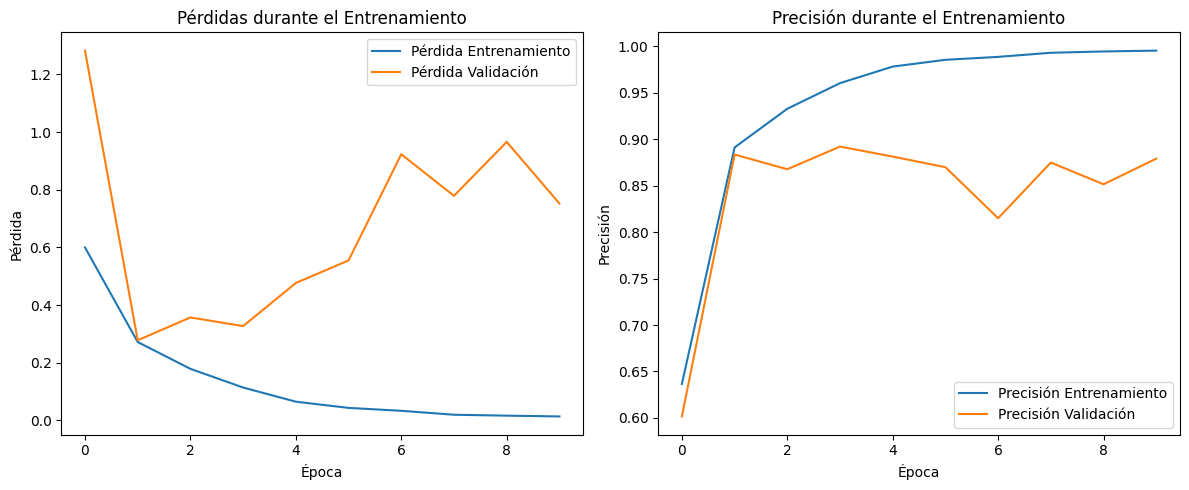


Evaluación del modelo:
Precisión: 0.8606
Recall: 0.9071
F1-Score: 0.8833


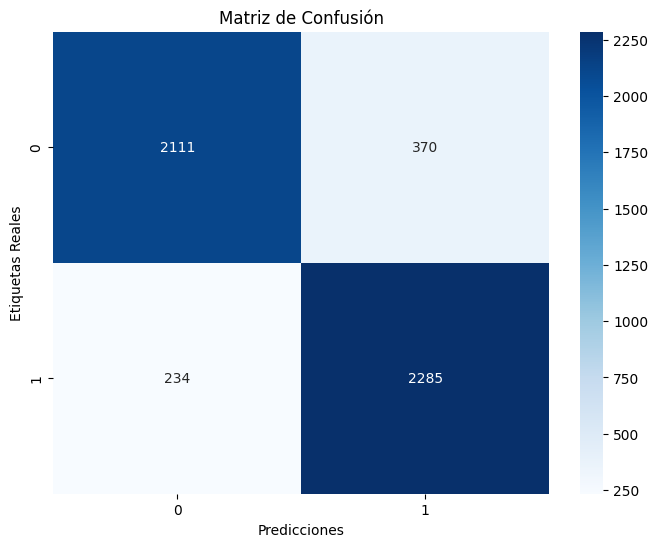

In [10]:
# Carga de datos
df = pd.read_csv('workspace/IMDB Dataset.csv')

# Preprocesamiento
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.1, random_state=42
)

# Construcción de vocabulario
fasttext_embedder = FastTextEmbedding()
vocab = build_vocab(X_train)

# Obtener matriz de embeddings
embedding_matrix = fasttext_embedder.get_embedding_matrix(vocab)

# Datasets
train_dataset = IMDBDataset(X_train.values, y_train.values, vocab, fasttext_embedder)
test_dataset = IMDBDataset(X_test.values, y_test.values, vocab, fasttext_embedder)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Modelo
model = SentimentRNN(
    vocab_size=len(vocab),
    embedding_matrix=embedding_matrix,
    hidden_dim=256,
    output_dim=2  # Binario: positivo/negativo
).to(device)

# Configuración de entrenamiento
num_epochs = 20

'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
'''

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.001, 
    weight_decay=0.01,  # Regularización L2 más agresiva
    amsgrad=True        # Variante de Adam más estable
)

# Scheduler de learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=20,           # Número de épocas
    eta_min=1e-5        # Learning rate mínimo
)

# Entrenamiento
print("Iniciando entrenamiento...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, 
    train_loader, 
    test_loader,  # Usando test_loader como validación 
    criterion, 
    optimizer, 
    num_epochs
)

# Visualización de pérdidas y precisiones
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Pérdida Entrenamiento')
plt.plot(val_losses, label='Pérdida Validación')
plt.title('Pérdidas durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Precisión Entrenamiento')
plt.plot(val_accuracies, label='Precisión Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluación del modelo
print("\nEvaluación del modelo:")
evaluate_model(model, test_loader)